## Codigo fonte da implementação do landlab para shield stress
> https://github.com/landlab/landlab/blob/c930a865722cb5f4bc6e68afafe81eb9615fed57/landlab/components/stream_power/sed_flux_dep_incision.py

## Import dependencies

In [2]:
from landlab.components import FlowAccumulator, SedDepEroder,FastscapeEroder
from landlab import RasterModelGrid
import landlab
import numpy as np
import statistics 
from pylab import show, figure
from landlab.io import read_esri_ascii
from landlab import Component
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

## Load DEM

In [3]:
(mg, z) = read_esri_ascii("./save_asc/ascii_cropadotest.asc", name="topographic__elevation")
mg.at_node.keys()#lista os grids contidos no DEM

['topographic__elevation']

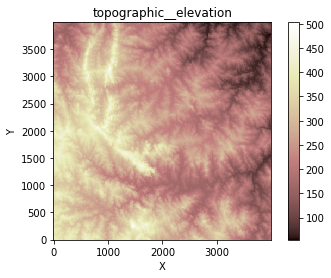

In [4]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation') #mostra o DEM

## Create shear stress component

In [6]:
class Shear_Stress(Component): #classe do componente criado
    
    _name = "Shear_Stress"
    
    #parametros iniciais do objeto 
    def __init__(self, dem, fluid_density=1000, g=9.80665, mannings_n=0.05, k_w=2.5, runoff=1, k_Q=2.5e-07, b_sp=0.5, c_sp=1):
                        
        self._dem = dem
        self._runoff = runoff #The rate of excess overland flow production at each node (i.e.,rainfall rate less infiltration).
        self._k_Q = k_Q   #Prefactor on A**c_sp to give discharge.
        self._b_sp = b_sp #Power on drainage area to give channel width.
        self._c_sp = c_sp # Power on drainage area to give discharge.
        self._g = g  #gravidade 
        self._k_w = k_w   #Prefactor on A**b_sp to give channel width.
        self._mannings_n = mannings_n
        self._fluid_density = fluid_density
        # pgd da formula do shear stress
        self._shear_stress_coeficient_p1 = self._fluid_density * self._g * (self._mannings_n / self._k_w) ** 0.6 
        # segunda parte da formula
        self._shear_stress_coeficient_p2 = 0.6 * (1.0 - self._b_sp) 
    
    def discrete_shear_stress(self, ss): # divisao do shear stress para escala de tamnhos da escala de Roux (1998)
    
        if ss <= 0:
            return 0
        if ss <= 1:
            return 1
        if ss <= 1.2710:
            return 1.2710
        if ss <= 1.7423:
            return 1.7423
        if ss <= 2.1964:
            return 2.1964
        if ss <= 2.8541:
            return 2.8541
        if ss <= 6.6074:
            return 6.6074
        if ss <= 14.503:
            return 14.503
        if ss <= 29.138:
            return 29.138
        if ss <= 58.275:
            return 58.275

        return 60

        
    def run_one_step(self):
        dem = self._dem
        node_z = dem.at_node["topographic__elevation"] #elevaçao
        node_A = dem.at_node["drainage_area"] #area de drenagem, vem do flow accumulator
        node_S = dem.at_node["topographic__steepest_slope"] #slope
        
        node_Q = self._k_Q * self._runoff * node_A ** self._c_sp # Calcula profundidade, parte que tem a ver com PAR_1, PAR_2 
        #shear stress usando a profundidade
        shear_stress_prefactor_timesAparts = (self._shear_stress_coeficient_p1 * node_Q ** self._shear_stress_coeficient_p2)
        counter=0
        
        while 1:
            
            #funçao clip atribui o valor zero a valores negativos que venham a ser encontrados
            #depressoes podem possuir valores negativos (lago, fosso, buraco negro)
            downward_slopes = node_S.clip(0.0) 
            slopes_tothe07 = downward_slopes ** 0.7
            shear_stress = shear_stress_prefactor_timesAparts * slopes_tothe07 #multiplica o pre fator do shear stress pelo slope e calcula o shear stress
            shear_stress_discrete = list(map(self.discrete_shear_stress, shear_stress)) #classifica os resultados anteriores com o intervalo definido
            
            #adiciona grid ao DEM
            if 'shear_stress' in mg.at_node.keys():
                mg.delete_field("node","shear_stress")

            mg.add_field("shear_stress", shear_stress, at="node", copy=True, clobber=False)
            
            if 'shear_stress_discrete' in mg.at_node.keys():
                mg.delete_field("node","shear_stress_discrete")
                
            mg.add_field("shear_stress_discrete", shear_stress_discrete, at="node", copy=True, clobber=False)
            
            self.d50 = (node_Q * slopes_tothe07) / 0.05
            self.d = node_Q
            self.S = slopes_tothe07
            
            break_flag = True
            if break_flag:
                    break


    def calc_d50(self):
        return self.d50




## Create components

In [7]:
fda = FlowAccumulator(mg, 'topographic__elevation') #cria o componente flow accumulator
css = Shear_Stress(mg) #cria o componente shear stress
sp = FastscapeEroder(mg) #cria o componente fast scape eroder

## Run Component

In [8]:
#for i in range(10):
fda.run_one_step()
sp.run_one_step(dt=10)#dt em anos 
css.run_one_step() 

In [9]:
css.S

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [10]:
mg.add_field("cd50", grain_type, at="node", copy=True, clobber=False)

NameError: name 'grain_type' is not defined

In [ ]:
grain_type = list(map(classify_grain, css.d50))

In [ ]:
landlab.plot.imshow.imshow_grid_at_node(mg,'cd50', cmap='Dark2')

In [ ]:
def classify_grain(size):
    if size <= 0.004:
        return 1
    if size <= 0.062:
        return 2
    if size <= 0.25:
        return 3
    if size <= 0.5:
        return 4
    if size <= 1:
        return 5
    if size <= 4:
        return 6
    
    return 7
    

## Plot results

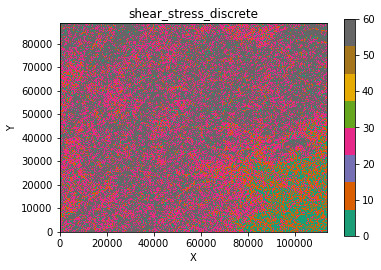

In [11]:
landlab.plot.imshow.imshow_grid_at_node(mg,'shear_stress_discrete', cmap='Dark2')

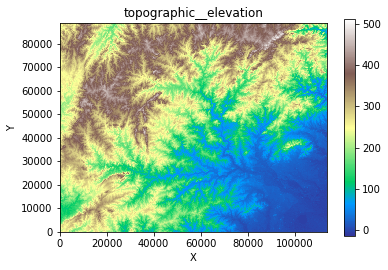

In [12]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation', cmap='terrain')

## Run again

In [13]:
fda.run_one_step()
sp.run_one_step(dt=100000)
css.run_one_step() #dt em anos

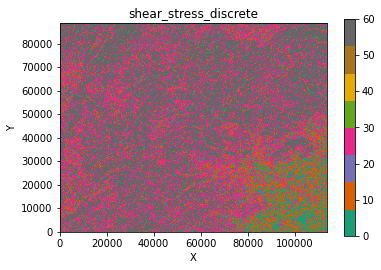

In [14]:
landlab.plot.imshow.imshow_grid_at_node(mg,'shear_stress_discrete', cmap='Dark2')

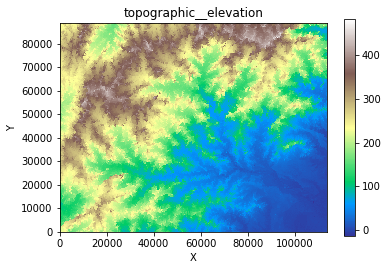

In [15]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation', cmap='terrain')